In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
# include("../src/worker_fct.jl")
data_type = "cal";
set = "sim";
high_cut = 4;

In [2]:
plots_path = "../plots/sim/"
base_path  = joinpath("../../waveforms/sim/", "wf")
base_path_AE  = joinpath("../../waveforms/sim/", "calib_AE")

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)

photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2103.5, 2614.5]; # keV

In [3]:
# cal done: all
# A/E done: all
ch = 17
ch_str = lpad(ch, 2, "0")
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
data = HDF5.h5open(filepath, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end;

In [5]:
calib[ctn[ch]][set]["AE_norm"]

0.0604

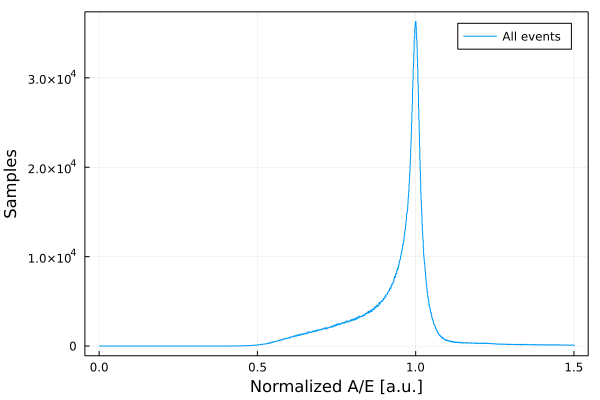

In [8]:
calib = JSON.parsefile(calib_filepath)
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
h = fit(Histogram, AoE, 0:0.0001:0.3)
AE_norm = h.edges[1][findfirst(x->x == maximum(h.weights), h.weights)]
AoE ./= AE_norm
h = fit(Histogram, AoE, 0:0.001:1.5)
calib[ctn[ch]][set]["AE_norm"] = AE_norm
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end
p = plot(h, st=:step, label="All events")
p = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", framestyle=:box)
filename = joinpath(plots_path, "AoverE_all-events_norm.pdf")
# savefig(p, filename)
display(p)

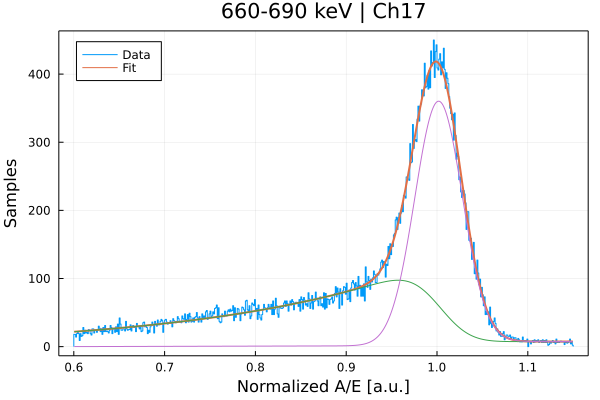

In [9]:
for ch in [17]
    ch_str = lpad(ch, 2, "0");
    if !ctb[ch]
        println("STOP here! This is a coax detector.")
    else
        if !haskey(calib, ctn[ch])
            calib[ctn[ch]] = Dict()
            calib[ctn[ch]]["data"] = Dict()
            calib[ctn[ch]]["sim"] = Dict()
        end

        calib = JSON.parsefile(calib_filepath)
        filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
        data = HDF5.h5open(filepath, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        plots_base_path = joinpath(plots_path, ch_str * "-" * ctn[ch] * "/" *set * "/")
        slice_lib_filepath = "../dicts/slice_lib.json"
        slice_filepath = "../dicts/slices_sim/"
        slice_lib = JSON.parsefile(slice_lib_filepath)
        slices = [600, 630, 660, 800, 895, 925, 955, 985, 1015, 1045,
                1130, 1160, 1190, 1220, 1250, 1280, 1310, 1340, 1370, 1400, 1430, 1460, 1545,
                1665, 1695, 1725, 1755, 1785, 1815, 1845, 1875, 1905, 1935, 
                1965, 1995, 2025, 2055,
                2145, 2175, 2205, 2235, 2265, 2295, 2325];
        overwrite = true
        for slice in [1,2,3]#eachindex(slices)
#         for slice in eachindex(slices)[1:1]
            slice_lib_filepath = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice], 4, "0") * ".json")
            if !isfile(slice_lib_filepath) || overwrite

                slice_lib = Dict()
                !haskey(slice_lib, ctn[ch]) ? slice_lib[ctn[ch]] = Dict() : ""
                !haskey(slice_lib[ctn[ch]], set) ? slice_lib[ctn[ch]][set] = Dict() : ""
                !haskey(slice_lib[ctn[ch]][set], "AE_slices") ? slice_lib[ctn[ch]][set]["AE_slices"] = Dict() : ""

                !isdir(dirname(slice_lib_filepath)) ? mkpath(dirname(slice_lib_filepath)) : ""
                open(slice_lib_filepath, "w") do f
                    JSON.print(f, slice_lib, 4)
                end
                slice_lib = JSON.parsefile(slice_lib_filepath)
                calib = JSON.parsefile(calib_filepath)
                @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " (" * set * ")")

                E = deepcopy(data.E)
                A = deepcopy(data.A)
                AoE = A ./ E
                AoE ./= calib[ctn[ch]][set]["AE_norm"]
                index = findall(x -> x >= slices[slice] && x < slices[slice] + 30, E);
                rng_start = 0.7
                rng_end = 1.05
                rng_step = 0.001
                h = fit(Histogram, AoE[index], rng_start-0.1:rng_step:rng_end+0.1);

                if slice > 1
                    last_file = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice-1], 4, "0") * ".json")
                    tmp = JSON.parsefile(last_file)
                    use_past = haskey(tmp[ctn[ch]], set)
                    if use_past
                        use_past = haskey(tmp[ctn[ch]][set]["AE_slices"], string(slices[slice - 1]))
                    end
                else
                    use_past = false
                    last_file = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice], 4, "0") * ".json")
                end
                prior_big = NamedTupleDist(
                    n = 20000..150000,
                    σ = 0.01..0.075,
                    μ = 0.98..1.02,
                    bkg_l = 0.1..3.0,
                    bkg_r = 10..500.0,
                    c = 50000..200000,
                    d = 100..10000.0,
                    β = 0.1..0.9
                )
                if slice == 1 || !use_past
                    prior = NamedTupleDist(
                        n = 20000..150000,
                        σ = 0.01..0.075,
                        μ = 0.98..1.02,
                        bkg_l = 0.1..3.0,
                        bkg_r = 10..500.0,
                        c = 50000..200000,
                        d = 100..10000.0,
                        β = 0.1..0.9
                    )
                else
                    slice_lib_last = JSON.parsefile(last_file)
                    par_dict = slice_lib_last[ctn[ch]][set]["AE_slices"][string(slices[slice - 1])]["peak"][1]
                    p0 = (
                        n = par_dict["n"],
                        σ = par_dict["σ"],
                        μ = par_dict["μ"],
                        bkg_l = par_dict["bkg_l"],
                        bkg_r = par_dict["bkg_r"],
                        c = par_dict["c"],
                        d = par_dict["d"],
                        β = par_dict["β"]
                    )
                    vary = 2
                    println(p0)
                    prior = NamedTupleDist(
                        n = p0.n/(2*vary)..p0.n*(2*vary),
                        σ = p0.σ/vary..p0.σ*vary,
                        μ = 0.98..1.02,
                        bkg_l = p0.bkg_l/vary..p0.bkg_l*vary,
                        bkg_r = p0.bkg_r/vary..p0.bkg_r*vary,
                        c = p0.c/(2*vary)..p0.c*vary,
                        d = p0.d/vary..p0.d*vary,
                        β = p0.β/vary..p0.β*vary
                    )
                end
                fail = false
                @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " (" * set * ")")
                samples = try bat_fit(h, peak, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=false);
                catch
                    IJulia.clear_output(true)
                    @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " (" * set * ")")
                    @info("Second try")
                    try bat_fit(h, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
                    catch
                        IJulia.clear_output(true)
                        @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " (" * set * ")")
                        @info("Third try")
                        try bat_fit(h, peak, prior; nsamples=2*10^6, nchains=4, params_first=false, norm_expected=false);
                        catch
                            IJulia.clear_output(true)
                            @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " (" * set * ")")
                            @info("Fourth try - open priors")
                            try bat_fit(h, peak, prior_big; nsamples=2*10^6, nchains=4, params_first=false, norm_expected=false);
                            catch
                                fail = true
                            end
                        end
                    end
                end
                p2 = plot();
                if !fail
                    par, err = mode(samples), std(samples)
                    x_fit = float.(midpoints(h.edges[1]))
                    y_fit = peak(x_fit, par)
                    y_fit ./= sum(y_fit)
                    y_fit .*= sum(h.weights)

                    par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
                    y_tail = peak(x_fit, par_tail)
                    y_tail ./= sum(y_tail)
                    y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
                    y_tail .*= sum(h.weights)

                    par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = 0, d = par.d, β = par.β)
                    y_gauss = peak(x_fit, par_gauss)
                    y_gauss ./= sum(y_gauss)
                    y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
                    y_gauss .*= sum(h.weights)

                    !haskey(slice_lib[ctn[ch]][set]["AE_slices"], string(slices[slice])) ? slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])] = Dict() : ""
                    slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["peak"] = [par, err]
                    slice_filepath
                    open(slice_lib_filepath, "w") do f
                        JSON.print(f, slice_lib, 4)
                    end

                    E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
                    p2 = plot!(h, st=:step, label="Data");
                    p2 = plot!(x_fit, y_fit, label="Fit", lw=2);
                    p2 = plot!(x_fit, y_tail, label="");
                    p2 = plot!(x_fit, y_gauss, label="");
                    p2 = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", title=E_range * " keV | Ch$ch_str", framestyle=:box, legend=:topleft);
                    filename = joinpath(plots_base_path, "AE_slices/" * lpad(slices[slice], 4, "0") * "-peak_model.png")
                    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
                    savefig(p2, filename);
                    IJulia.clear_output(true)
                    display(p2)
                end
            end
        end
    end
end

In [11]:
slice_lib_filepath = "../dicts/slice_lib.json"
slice_filepath = "../dicts/slices_sim/"
slice_lib = JSON.parsefile(slice_lib_filepath)
glob(slice_filepath * "*/*")

1321-element Vector{String}:
 "../dicts/slices_sim/00/0600.json"
 "../dicts/slices_sim/00/0630.json"
 "../dicts/slices_sim/00/0660.json"
 "../dicts/slices_sim/00/0800.json"
 "../dicts/slices_sim/00/0895.json"
 "../dicts/slices_sim/00/0925.json"
 "../dicts/slices_sim/00/0955.json"
 "../dicts/slices_sim/00/0985.json"
 "../dicts/slices_sim/00/1015.json"
 "../dicts/slices_sim/00/1045.json"
 "../dicts/slices_sim/00/1130.json"
 "../dicts/slices_sim/00/1160.json"
 "../dicts/slices_sim/00/1190.json"
 ⋮
 "../dicts/slices_sim/35/1935.json"
 "../dicts/slices_sim/35/1965.json"
 "../dicts/slices_sim/35/1995.json"
 "../dicts/slices_sim/35/2025.json"
 "../dicts/slices_sim/35/2055.json"
 "../dicts/slices_sim/35/2145.json"
 "../dicts/slices_sim/35/2175.json"
 "../dicts/slices_sim/35/2205.json"
 "../dicts/slices_sim/35/2235.json"
 "../dicts/slices_sim/35/2265.json"
 "../dicts/slices_sim/35/2295.json"
 "../dicts/slices_sim/35/2325.json"

In [15]:
slice_lib_filepath = "../dicts/slice_lib.json"
slice_filepath = "../dicts/slices_sim/"
slice_lib = JSON.parsefile(slice_lib_filepath)
for file in glob(slice_filepath * "*/*")
    tmp = JSON.parsefile(file)
    for (k,v) in tmp
        !haskey(slice_lib, k) ? slice_lib[k] = Dict() : ""
        for (k1,v1) in tmp[k]
            !haskey(slice_lib[k], k1) ? slice_lib[k][k1] = Dict() : ""
            !haskey(slice_lib[k][k1], "AE_slices") ? slice_lib[k][k1]["AE_slices"] = Dict() : ""
            for (slice, val) in v1["AE_slices"]
                slice_lib[k][k1]["AE_slices"][slice] = val
            end
        end
    end
end
open(slice_lib_filepath, "w") do f
    JSON.print(f, slice_lib, 4)
end

# Check single slices

In [ ]:
ch = 14
ch_str = lpad(ch, 2, "0");
if !ctb[ch]
    println("STOP here! This is a coax detector.")
else
    if !haskey(calib, ctn[ch])
        calib[ctn[ch]] = Dict()
        calib[ctn[ch]]["data"] = Dict()
        calib[ctn[ch]]["sim"] = Dict()
    end

    calib = JSON.parsefile(calib_filepath)
    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "/AE_calibrated_smeared.h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    plots_base_path = joinpath(plots_path, ch_str * "-" * ctn[ch] * "/" *set * "/")
    slice_lib_filepath = "../dicts/slice_lib.json"
    slice_filepath = "../dicts/slices_sim/"
    slice_lib = JSON.parsefile(slice_lib_filepath)
    slices = [600, 630, 660, 800, 895, 925, 955, 985, 1015, 1045,
            1130, 1160, 1190, 1220, 1250, 1280, 1310, 1340, 1370, 1400, 1430, 1460, 1545,
            1665, 1695, 1725, 1755, 1785, 1815, 1845, 1875, 1905, 1935, 
            1965, 1995, 2025, 2055,
            2145, 2175, 2205, 2235, 2265, 2295, 2325];
end;

In [ ]:
    slice = 4
# for slice in 1:1:44
    if haskey(slice_lib[ctn[ch]][set]["AE_slices"], string(slices[slice]))
        E = deepcopy(data.E)
        A = deepcopy(data.A)
        AoE = A ./ E
        AoE ./= calib[ctn[ch]][set]["AE_norm"]
        index = findall(x -> x >= slices[slice] && x < slices[slice] + 30, E);
        rng_start = 0.4
        rng_end = 1.0
        h = fit(Histogram, AoE[index], rng_start-0.1:0.0005:rng_end+0.1);

        par_dict = slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["peak"][1]
        par = (
            n = par_dict["n"],
            σ = par_dict["σ"],
            μ = par_dict["μ"],
            bkg_l = par_dict["bkg_l"],
            bkg_r = par_dict["bkg_r"],
            c = par_dict["c"],
            d = par_dict["d"],
            β = par_dict["β"]
        )
        par_dict = slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["peak"][2]
        err = (
            n = par_dict["n"],
            σ = par_dict["σ"],
            μ = par_dict["μ"],
            bkg_l = par_dict["bkg_l"],
            bkg_r = par_dict["bkg_r"],
            c = par_dict["c"],
            d = par_dict["d"],
            β = par_dict["β"]
        )

        x_fit = float.(midpoints(h.edges[1]))
        y_fit = peak(x_fit, par)
        y_fit ./= sum(y_fit)
        y_fit .*= sum(h.weights)

        par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
        y_tail = peak(x_fit, par_tail)
        y_tail ./= sum(y_tail)
        y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
        y_tail .*= sum(h.weights)

        par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = 0, d = par.d, β = par.β)
        y_gauss = peak(x_fit, par_gauss)
        y_gauss ./= sum(y_gauss)
        y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
        y_gauss .*= sum(h.weights)

        E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
        p = plot(h, st=:step, label="Data");
        p = plot!(x_fit, y_fit, label="Fit", lw=2);
        p = plot!(x_fit, y_tail, label="");
        p = plot!(x_fit, y_gauss, label="");
        p = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", title=E_range * " keV | Ch$ch_str", legend=:outertop, size=(1000,600));
        # println("n -> ", par_old.n/2, " <= ", par.n, " <= ", par_old.n*2)
        # println("σ -> ", par_old.σ/2, " <= ", par.σ, " <= ", par_old.σ*2)
        # println("µ -> ", 0.98, " <= ", par.µ, " <= ", 1.02)
        # println("bkg_l -> ", par_old.bkg_l/2, " <= ", par.bkg_l, " <= ", par_old.bkg_l*2)
        # println("bkg_r -> ", par_old.bkg_r/2, " <= ", par.bkg_r, " <= ", par_old.bkg_r*2)
        # println("c -> ", par_old.c/2, " <= ", par.c, " <= ", par_old.c*2)
        # println("d -> ", par_old.d/2, " <= ", par.d, " <= ", par_old.d*2)
        # println("β -> ", par_old.β/2, " <= ", par.β, " <= ", par_old.β*2)
        IJulia.clear_output(true)
        display(p)
        @info("Slice $slice")
        sleep(1)
    else
        IJulia.clear_output(true)
        @info("Slice $slice not included!!")
        sleep(3)
    end
# end